<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/StackOverflowTags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os

In [2]:
URL = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file(
    'stackoverflow',
    origin=URL,
    extract=True,
    cache_dir=".",
    cache_subdir=""
)

6062080/6053168 [==============================] - 0s 0us/step


In [3]:
!ls -l

total 5928
-rw-r--r-- 1 206704 89939     529 Jul  8  2020 README.md
drwxr-xr-x 1 root   root     4096 Sep 14 13:44 sample_data
-rw-r--r-- 1 root   root  6053168 Sep 20 19:26 stackoverflow
drwxr-xr-x 6 206704 89939    4096 May 26  2020 test
drwxr-xr-x 6 206704 89939    4096 May 26  2020 train


In [18]:
BATCH_SIZE = 32
seed = 123

train_ds = tf.keras.utils.text_dataset_from_directory(
    "train",
    seed=seed,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    batch_size=BATCH_SIZE
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [19]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    "train",
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
    batch_size=BATCH_SIZE
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [20]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    "test",
    shuffle=True,
    batch_size=BATCH_SIZE
)

Found 8000 files belonging to 4 classes.


In [21]:
class_names = train_ds.class_names

In [22]:
train_ds = train_ds.shuffle(1000)
val_ds = val_ds.shuffle(1000)
test_ds = test_ds.shuffle(1000)

In [23]:
for text_batch, labels_batch in train_ds.take(1):
  for i in range(3):
    print(f"Text: {text_batch[i]}")
    print(f"Label: {class_names[labels_batch[i]]}")

Text: b'"how to format signed currency i have the following scenario. a decimal value needs to be displayed as a currency but include the appropriate currency symbol and sign, thus:...-45.23 is displayed as -\xc2\xa345.23.45.23 is displayed as +\xc2\xa345.23...the currency sign must come from system.globalization.cultureinfo.currentculture.numberformat.currencysymbol. i have this, but i can\'t find a way to swap the sign and currency symbol:..string s1 = string.format(@""{1}{0:+#,##0.00;-#,##0.00}"", 45.09m, .    system.globalization.cultureinfo.currentculture.numberformat.currencysymbol);.console.writeline(s2);.string s2 = string.format(@""{1}{0:+#,##0.00;-#,##0.00}"", -45.09m, .    system.globalization.cultureinfo.currentculture.numberformat.currencysymbol);.console.writeline(s2);...outputs:..\xc2\xa3+45.09.\xc2\xa3-45.09...i want:..+\xc2\xa345.09.-\xc2\xa345.09...update..someone posted another answer regarding the numberformatinfo.currencypositivepattern property, which looked promi

In [49]:
def custom_standardization(inputs):
  lowercase = tf.strings.lower(inputs)
  return tf.strings.regex_replace(
      lowercase, '[.,]', " "
  )

In [50]:
max_features = 20000
sequence_length = 400

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    output_sequence_length=sequence_length,
    max_tokens=max_features
)

In [51]:
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [52]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [53]:
text_batch, labels_batch = next(iter(train_ds))
print(f"Text: {text_batch[0]}")
print(f"Label: {class_names[labels_batch[0]]}")
print(f"Processed text: {vectorize_text(text_batch[0], labels_batch[0])}")

Text: b'"how could i get a random string from a list and assign it to a variable my list is defined as:..list&lt;string&gt; firstnames = new list&lt;string&gt;();...when i add some strings to this list, how would i go about retrieving a random string from the list? something like:..string currname = somefunctionof (firstnames);"\n'
Label: csharp
Processed text: (<tf.Tensor: shape=(1, 400), dtype=int64, numpy=
array([[ 110,  184,    4,   58,    6,  263,   23,   34,    6,   67,   11,
         678,   16,    5,    6,  129,   26,   67,    9,  534, 1711, 1155,
           1,    3,   19, 3024,   52,    4,  152,  107,  455,    5,   13,
          67,   38,   75,    4,  392,  249, 5676,    6,  263,   23,   34,
           2, 1879,  158,  747,   23,    1,    3,    1,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  

In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
embedding_dim = 16

model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(max_features+1, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

In [58]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [59]:
EPOCHS = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/10
200/200 [==============================] - 3s 8ms/step - loss: 1.3757 - accuracy: 0.3942 - val_loss: 1.3628 - val_accuracy: 0.4369
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 1.3403 - accuracy: 0.5130 - val_loss: 1.3180 - val_accuracy: 0.5188
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 1.2783 - accuracy: 0.5803 - val_loss: 1.2508 - val_accuracy: 0.5769
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 1.1984 - accuracy: 0.6430 - val_loss: 1.1722 - val_accuracy: 0.6438
Epoch 5/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1086 - accuracy: 0.6920 - val_loss: 1.0928 - val_accuracy: 0.6881
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 1.0232 - accuracy: 0.7294 - val_loss: 1.0200 - val_accuracy: 0.7306
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.9461 - accuracy: 0.7733 - val_loss: 0.9547 - val_accuracy: 0.7544
Epoch 

In [60]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


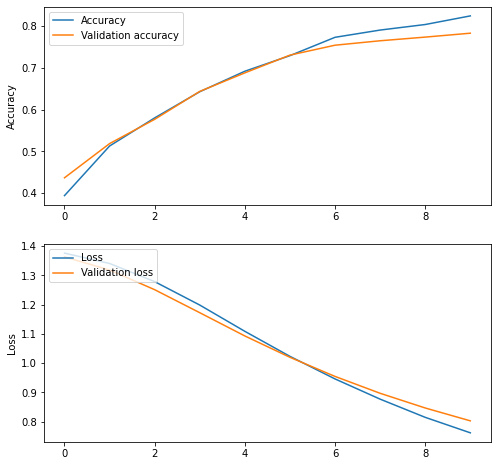

In [61]:
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label="Accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(loss, label="Loss")
plt.plot(val_loss, label="Validation loss")
plt.ylabel("Loss")
plt.legend(loc="upper left")

plt.show()

In [62]:
loss, acc = model.evaluate(test_ds)
print(f"Accuracy: {acc}")

250/250 [==============================] - 1s 2ms/step - loss: 0.7917 - accuracy: 0.7950
Accuracy: 0.7950000166893005


In [70]:
features = ["Question regarding numpy. for i in range(1): print('hi') javascript javascript def func(): print('ja')"]

import numpy as np

print(class_names[np.argmax(model.predict(features))])

python
